In [9]:
import pandas as pd
import datetime as dt
import numpy as np
import os

import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [10]:
# Read data
data = pd.read_csv('../../data/model_features.csv')
# data = pd.read_csv('../data/transformed_data_men_21_to_24.csv')
# data.drop('Unnamed: 0',axis=1,inplace=True)
data.columns = [col.replace('%','_perc') for col in data.columns]
data.columns = [col.replace('3','three_') for col in data.columns]
data.head()

,won,underdog,underdog_opp,fan_favorite,fan_favorite_opp,de,oe,te,pace,physicality_score,...,luck_opp,choke_rate,choke_rate_opp,upset_rate,upset_rate_opp,three_mean_plus_minus,three_mean_plus_minus_opp,win_streak,win_streak_opp,matchup_win_rate
0,0,0,0,0,1,105.987988,105.321996,0.993716,67.0,8.483871,...,0.142857,NaN,NaN,NaN,0.500000,-23.333333,1.000000,0,0,NaN
1,0,0,0,0,1,105.987988,105.321996,0.993716,67.0,8.483871,...,0.444444,NaN,NaN,NaN,0.500000,-23.333333,24.000000,0,1,NaN
2,0,0,0,0,1,105.987988,105.321996,0.993716,67.0,8.483871,...,0.300000,NaN,NaN,NaN,0.142857,-23.333333,5.000000,0,0,NaN
3,0,0,0,0,1,105.987988,105.321996,0.993716,67.0,8.483871,...,0.166667,NaN,0.380952,NaN,0.285714,-23.333333,45.333333,0,1,NaN
4,0,0,0,0,1,105.987988,105.321996,0.993716,67.0,8.483871,...,0.500000,NaN,NaN,NaN,0.000000,-37.666667,-1.333333,0,0,NaN


In [3]:
# Check for duplicates
num_duplicates = data.loc[data.duplicated()].shape[0]
print(f'{num_duplicates} duplicates')
if num_duplicates > 0:
#     print(data.loc[data.duplicated()].head())
    data = data.drop_duplicates()
    print('duplicates removed')

0 duplicates


## Create helper functions

In [4]:
def get_odds_ratios(model, save_name=None):
    # Build a dataframe with odds ratios and their confidence intervals.
    if type(model) in [type(LogisticRegression()), type(XGBClassifier())]:
#         params = np.concatenate((model.intercept_, model.coef_[0]),axis=0)
        params = pd.Series(model.coef_[0],index=model.feature_names_in_)
    else:
        params = model.params
    odds_ratios = pd.DataFrame(
        {
            "OR": params
#             "Lower CI": model.conf_int()[0],
#             "Upper CI": model.conf_int()[1],
        }
    )
    # Exponentiate the data frame
    odds_ratios = np.exp(odds_ratios)

    # Print the odds ratios
#     or_string = 
    print('\nOdds Ratios:')
    print(odds_ratios.sort_values('OR',ascending=False))
    odds_ratios.sort_values('OR',ascending=False).to_csv(f'../../eda/{save_name}_odds_ratios.csv')
    
    # Print prediction table
    if type(model) not in [type(LogisticRegression()), type(XGBClassifier())]:
        print('\nPrediction table:')
        print(model.pred_table())
    if save_name is not None:
        np.savetxt(f'../../eda/{save_name}_prediction_table.out',model.pred_table(),
                   header=f'{save_name} prediction table')
    
    return None

In [5]:
def get_confusion_matrix(model, validation, response_var):
    y_pred = model.predict(validation)
    prediction = list(map(round, y_pred))

    # Create a sklearn confusion matrix
    cm = confusion_matrix(validation[response_var], prediction)
    print ("\nConfusion Matrix : \n", cm)

    # We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
    print('\nTest accuracy = ', accuracy_score(validation[response_var], prediction))
    
    # Print classfication report
    print('\nClassification Report: \n' , classification_report(validation[response_var],prediction))
    
    return None

## 1 - Statsmodels Logistic Regression - fillna

         Current function value: 0.451122
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
Accuracy: 0.7689777327935222
F1-Score: 0.7689192609465958
ROC/AUC Score for Logistic Regression:  0.7690093527647092


C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


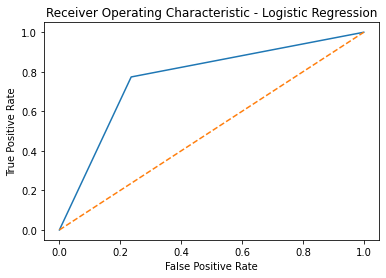

In [6]:
resp_var = data.columns[0]
pred_vars = data.columns[1:].tolist()

train, test = train_test_split(data.fillna(0),test_size=0.1)
logit_phrase = resp_var + ' ~ ' + ' + '.join(pred_vars)
log_reg = sm.logit(logit_phrase, data=train).fit(method='bfgs')
y_pred = log_reg.predict(test)
prediction = list(map(round, y_pred))

false_positive_rate, true_positive_rate, threshold1 = roc_curve(test[resp_var], prediction)
print(f'Accuracy: {accuracy_score(test[resp_var], prediction)}')
print(f'F1-Score: {f1_score(test[resp_var], prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(test[resp_var], prediction))

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [7]:
get_odds_ratios(log_reg)


Odds Ratios:
                         OR
matchup_win_rate   8.641028
luck               2.465747
game_win_rate      1.583408
fan_favorite       1.577754
upset_rate         1.238221
...                     ...
poss_per_game      0.854410
upset_rate_opp     0.823700
game_win_rate_opp  0.647600
fan_favorite_opp   0.624751
luck_opp           0.418688

[84 rows x 1 columns]

Prediction table:
[[13999.  3766.]
 [ 3996. 13805.]]


#### 1-A Remove possibly confounding features

In [8]:
data.columns
exclude_columns = ['matchup_win_rate','choke_rate','choke_rate_opp','luck','luck_opp',
                   'upset_rate','upset_rate_opp']
data2 = data.drop(exclude_columns, axis=1)
resp_var = data2.columns[0]
pred_vars = data2.columns[1:].tolist()

train, test = train_test_split(data2,test_size=0.1)
logit_phrase = resp_var + ' ~ ' + ' + '.join(pred_vars)
log_reg = sm.logit(logit_phrase, data=train).fit(method='bfgs')
y_pred = log_reg.predict(test)
prediction = list(map(round, y_pred))

false_positive_rate, true_positive_rate, threshold1 = roc_curve(test[resp_var], prediction)
print(f'Accuracy: {accuracy_score(test[resp_var], prediction)}')
print(f'F1-Score: {f1_score(test[resp_var], prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(test[resp_var], prediction))

         Current function value: 0.483770
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45
Accuracy: 0.7558198380566802
F1-Score: 0.757110495846967
ROC/AUC Score for Logistic Regression:  0.7558135127403371


C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


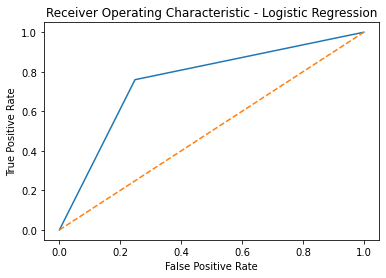

In [9]:
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [10]:
get_odds_ratios(log_reg)


Odds Ratios:
                         OR
game_win_rate      7.282876
underdog           1.728332
fan_favorite       1.510991
poss_per_game_opp  1.378765
fga_opp            1.207680
...                     ...
fga                0.815560
poss_per_game      0.722691
fan_favorite_opp   0.657924
underdog_opp       0.563528
game_win_rate_opp  0.139185

[77 rows x 1 columns]

Prediction table:
[[13547.  4234.]
 [ 4273. 13512.]]


## 1.C Statsmodels LogReg Run with a select set of features

In [11]:
include_columns = ['won','de','oe','te','de_opp','oe_opp','te_opp','three_mean_plus_minus', 'three_mean_plus_minus_opp',
                  'game_win_rate','game_win_rate_opp','physicality_score','physicality_score_opp','win_streak','win_streak_opp']
# include_columns = ['won','de','oe','te','de_opp','oe_opp','te_opp','three_mean_plus_minus', 'three_mean_plus_minus_opp',
#                   'physicality_score','physicality_score_opp']
data2 = data[include_columns]
resp_var = data2.columns[0]
pred_vars = data2.columns[1:].tolist()

train, test = train_test_split(data2,test_size=0.1)
logit_phrase = resp_var + ' ~ ' + ' + '.join(pred_vars)
log_reg = sm.logit(logit_phrase, data=train).fit(method='bfgs')
y_pred = log_reg.predict(test)
prediction = list(map(round, y_pred))

false_positive_rate, true_positive_rate, threshold1 = roc_curve(test[resp_var], prediction)
print(f'Accuracy: {accuracy_score(test[resp_var], prediction)}')
print(f'F1-Score: {f1_score(test[resp_var], prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(test[resp_var], prediction))
get_odds_ratios(log_reg)

         Current function value: 0.526097
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
Accuracy: 0.722419028340081
F1-Score: 0.7234686160826822
ROC/AUC Score for Logistic Regression:  0.7224727315014394

Odds Ratios:
                                   OR
game_win_rate              434.475740
win_streak_opp               1.074163
te_opp                       1.041300
Intercept                    1.031505
three_mean_plus_minus        1.029602
de                           1.021162
te                           1.019191
oe_opp                       1.011996
physicality_score            1.011705
physicality_score_opp        0.997694
oe                           0.987706
de_opp                       0.978479
three_mean_plus_minus_opp    0.972176
win_streak                   0.930494
game_win_rate_opp            0.002118

Prediction table:
[[13061.  4740.]
 [ 4770. 12995.]]


C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 2 - Sklearn Logistic Regression

In [12]:
y = data.iloc[:, 0] #selects the first column (wins)
X = data.iloc[:, 1:] #selects all columns except the win column
X.dropna(inplace=True,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = LogisticRegression(max_iter=1000)  # Increase max_iter if the model doesn't converge
model.fit(X_train, y_train)

prediction = model.predict(X_test)

false_positive_rate, true_positive_rate, threshold1 = roc_curve(
    y_test, model.predict_proba(X_test)[:,1])
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'F1-Score: {f1_score(y_test, prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(y_test, prediction))

get_odds_ratios(model)

Accuracy: 0.7555668016194332
F1-Score: 0.7467226009438909
ROC/AUC Score for Logistic Regression:  0.7555101169360137

Odds Ratios:
                           OR
game_win_rate      265.294265
poss_per_game_opp    1.784726
fan_favorite         1.590593
underdog             1.271224
tov_perc_opp         1.193621
...                       ...
fg_opp               0.875856
tov_perc             0.818667
fan_favorite_opp     0.630832
poss_per_game        0.560758
game_win_rate_opp    0.003826

[76 rows x 1 columns]


C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


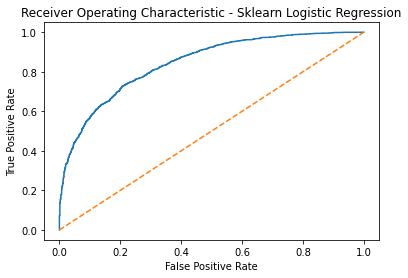

In [13]:
plt.title('Receiver Operating Characteristic - Sklearn Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3 - Xgboost

In [14]:
pd.options.display.max_columns = 100

In [15]:
model = XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100, 
    learning_rate = 0.02,
    max_depth = 5,
    gamma = 5,
    min_child_weight = 10,
    subsample = .8
)
model.fit(X_train, y_train)

prediction = model.predict(X_test)

false_positive_rate, true_positive_rate, threshold1 = roc_curve(
    y_test, model.predict_proba(X_test)[:,1])
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'F1-Score: {f1_score(y_test, prediction)}')
print('ROC/AUC Score for Xgboost: ', roc_auc_score(y_test, prediction))

# get_odds_ratios(model)

Accuracy: 0.7515182186234818
F1-Score: 0.7432008368200838
ROC/AUC Score for Xgboost:  0.7515664006043883


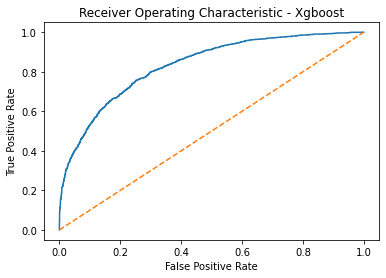

In [16]:
plt.title('Receiver Operating Characteristic - Xgboost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Grid Search for Xgboost

In [17]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [18]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1)

In [19]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

NameError: name 'params' is not defined

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

## Gradient Boosted Trees

In [ ]:
X.dropna(inplace=True, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Initialize the Gradient Boosting Classifier
gbt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model on the training data
gbt_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = gbt_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

## Hist Gradient Boosted Classifier

In [ ]:
y = data.iloc[:, 0] #selects the first column (wins)
X = data.iloc[:, 1:] #selects all columns except the win column
# X.dropna(inplace=True,axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Initialize the Histogram-based Gradient Boosting Classifier
hist_gbt_model = HistGradientBoostingClassifier(max_iter=100)

# Train the model on the training data
hist_gbt_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = hist_gbt_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

#### Perform Hyperparameter Tuning

In [ ]:
# Initialize the Histogram-based Gradient Boosting Classifier
hist_gbt_model = HistGradientBoostingClassifier()

# Define the hyperparameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [50, 100, 150],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization':[0,0.1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=hist_gbt_model, param_grid=param_grid, cv=3, scoring='accuracy')

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
predictions = best_model.predict(X_test)

# Evaluate the accuracy of the best model
accuracy = accuracy_score(y_test, predictions)
print(f"Best Parameters: {best_params}")
print(f"Best Model Accuracy: {accuracy * 100:.2f}%")

# Probablistic Models
### Gaussian Naive Bayes

In [ ]:
y = data.iloc[:, 0] #selects the first column (wins)
X = data.iloc[:, 1:] #selects all columns except the win column
X.dropna(inplace=True,axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Initialize the Gaussian Naive Bayes model
gnb_model = GaussianNB()

# Train the model on the training data
gnb_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = gnb_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Team-Centric Modeling

In [11]:
feature_cols

['won',
 'underdog',
 'underdog_opp',
 'fan_favorite',
 'fan_favorite_opp',
 'de',
 'oe',
 'te',
 'pace',
 'physicality_score',
 'sos',
 'srs',
 'fg',
 'fga',
 'fg_perc',
 'three_p',
 'three_pa',
 'three_p_perc',
 'ft',
 'fta',
 'ft_perc',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'pf',
 'tov',
 'tov_perc',
 'poss',
 'ast_per_poss',
 'ast_per_fg',
 'tov_per_poss',
 'ast_to_tov',
 'poss_per_game',
 'game_win_rate',
 'gpt_sent_score_avg',
 'de_opp',
 'oe_opp',
 'te_opp',
 'pace_opp',
 'physicality_score_opp',
 'sos_opp',
 'srs_opp',
 'fg_opp',
 'fga_opp',
 'fg_perc_opp',
 'three_p_opp',
 'three_pa_opp',
 'three_p_perc_opp',
 'ft_opp',
 'fta_opp',
 'ft_perc_opp',
 'orb_opp',
 'drb_opp',
 'trb_opp',
 'ast_opp',
 'stl_opp',
 'blk_opp',
 'pf_opp',
 'tov_opp',
 'tov_perc_opp',
 'poss_opp',
 'ast_per_poss_opp',
 'ast_per_fg_opp',
 'tov_per_poss_opp',
 'ast_to_tov_opp',
 'poss_per_game_opp',
 'game_win_rate_opp',
 'gpt_sent_score_avg_opp',
 'conf_rank',
 'conf_rank_opp',
 'luck',
 'luck_

In [12]:
datat.columns.tolist()

['team',
 'opponent',
 'won',
 'team_score',
 'opponent_score',
 'team_rank',
 'opponent_rank',
 'game_round',
 'season_type',
 'date',
 'season_year',
 'home_game',
 'underdog',
 'underdog_opp',
 'fan_favorite',
 'fan_favorite_opp',
 'g',
 'w',
 'l',
 'de',
 'oe',
 'te',
 'pace',
 'physicality_score',
 'sos',
 'srs',
 'fg',
 'fga',
 'fg_perc',
 'three_p',
 'three_pa',
 'three_p_perc',
 'ft',
 'fta',
 'ft_perc',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'pf',
 'tov',
 'tov_perc',
 'poss',
 'ast_per_poss',
 'ast_per_fg',
 'tov_per_poss',
 'ast_to_tov',
 'poss.1',
 'game_win_rate',
 'gpt_sent_score_avg',
 'g_opp',
 'w_opp',
 'l_opp',
 'de_opp',
 'oe_opp',
 'te_opp',
 'pace_opp',
 'physicality_score_opp',
 'sos_opp',
 'srs_opp',
 'fg_opp',
 'fga_opp',
 'fg_perc_opp',
 'three_p_opp',
 'three_pa_opp',
 'three_p_perc_opp',
 'ft_opp',
 'fta_opp',
 'ft_perc_opp',
 'orb_opp',
 'drb_opp',
 'trb_opp',
 'ast_opp',
 'stl_opp',
 'blk_opp',
 'pf_opp',
 'tov_opp',
 'tov_perc_opp',
 'poss_opp',


In [13]:
datat = pd.read_csv('../../data/transformed_data_men_15_to_24.csv')
datat.columns = [col.replace('%','_perc') for col in datat.columns]
datat.columns = [col.replace('3','three_') for col in datat.columns]

feature_cols = data.columns.tolist()
data1 = datat[['team']+feature_cols]

In [14]:
# Train model for each team
# Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': None, 'max_iter': 100, 'min_samples_leaf': 25}
# Best Histogram-based Gradient Boosting Classification Tree
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

team_accuracies = {}
combined_predictions = []
y_true = []
for team in datat.team.unique():
    df_tmp = data1.loc[data1.team == team, feature_cols]
    if df_tmp.shape[0] < 30:
        print('Not enough data to build a model')
        continue
        
    X = df_tmp.iloc[:,1:]
    y = df_tmp.iloc[:,0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    for scaler in [StandardScaler(), MinMaxScaler()]:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    model = HistGradientBoostingClassifier(
        learning_rate=0.05,
        min_samples_leaf=25)
    
    # Train the model on the training set
    model.fit(X_train, y_train)

    # Print model performance
    predictions = model.predict(X_test)
    
    team_accuracies[team] = f1_score(y_test, predictions.tolist())
    combined_predictions += predictions.tolist()
    y_true += y_test.tolist()

    
f1_score(y_true, combined_predictions)

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

Not enough data to build a model


C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

Not enough data to build a model


C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mea

0.710992818761613

In [15]:
sorted(team_accuracies.items(), key=lambda x:x[1], reverse=True)

[("Saint Mary's (CA)", 0.9400000000000001),
 ('Utah', 0.9230769230769231),
 ('Northwestern State', 0.9),
 ('Kansas', 0.897196261682243),
 ('Villanova', 0.8947368421052632),
 ('Michigan State', 0.8932038834951457),
 ('Gonzaga', 0.8852459016393442),
 ('Marquette', 0.875),
 ('Virginia', 0.8727272727272727),
 ('Stephen F. Austin', 0.8695652173913043),
 ('Western Michigan', 0.8695652173913043),
 ('New Mexico State', 0.8641975308641975),
 ('Arizona', 0.8627450980392156),
 ('Georgia', 0.8571428571428571),
 ('Wichita State', 0.8571428571428571),
 ('North Carolina', 0.8490566037735849),
 ('Purdue', 0.845360824742268),
 ('Belmont', 0.8444444444444444),
 ('Buffalo', 0.8433734939759037),
 ('Texas A&M Corpus Christi', 0.8421052631578948),
 ('Alcorn State', 0.8421052631578947),
 ('Louisville', 0.8421052631578947),
 ('Nevada', 0.8421052631578947),
 ('Vermont', 0.8421052631578947),
 ('Arkansas', 0.8351648351648352),
 ('UC Davis', 0.8333333333333333),
 ('Florida State', 0.8314606741573033),
 ('Sam Hous

In [17]:
len(y_true)

20357

In [82]:
datat.loc[datat.team == 'Fairleigh Dickinson']

,team,opponent,won,team_score,opponent_score,team_rank,opponent_rank,game_round,season_type,date,season_year,home_game,underdog,underdog_opp,fan_favorite,fan_favorite_opp,g,w,l,de,oe,te,pace,physicality_score,sos,srs,fg,fga,fg_perc,three_p,three_pa,three_p_perc,ft,fta,ft_perc,orb,drb,trb,ast,stl,blk,pf,tov,tov_perc,poss,ast_per_poss,ast_per_fg,tov_per_poss,ast_to_tov,poss_per_game,...,oe_opp,te_opp,pace_opp,physicality_score_opp,sos_opp,srs_opp,fg_opp,fga_opp,fg_perc_opp,three_p_opp,three_pa_opp,three_p_perc_opp,ft_opp,fta_opp,ft_perc_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,pf_opp,tov_opp,tov_perc_opp,poss_opp,ast_per_poss_opp,ast_per_fg_opp,tov_per_poss_opp,ast_to_tov_opp,poss_per_game_opp,game_win_rate_opp,gpt_sent_score_avg_opp,seed,conf,seed_opp,conf_opp,conf_rank,conf_rank_opp,plus_minus,luck,luck_opp,choke_rate,choke_rate_opp,upset_rate,upset_rate_opp,three_mean_plus_minus,three_mean_plus_minus_opp,win_streak,win_streak_opp,matchup_win_rate
9272,Fairleigh Dickinson,Quinnipiac,0,66.0,84.0,NaN,NaN,NaN,regular_season,2020/11/25,2021,0,0,0,0,1,24.0,9.0,15.0,109.772034,104.602875,0.952910,71.0,8.947917,-6.46,-10.17,26.875000,59.666667,0.450,8.083333,21.541667,0.375,13.208333,18.541667,0.712,10.166667,23.708333,33.875000,11.958333,7.583333,3.875000,18.291667,14.166667,17.1,39.682292,0.301352,0.444961,0.357002,0.844118,1.653429,...,92.178771,0.978261,72.0,8.022727,-7.60,-9.10,22.954545,57.181818,0.401,7.681818,23.727273,0.324,13.909091,20.227273,0.688,7.727273,28.318182,36.045455,12.681818,5.590909,4.545455,19.090909,14.227273,17.6,39.062500,0.324655,0.552475,0.364218,0.891374,1.775568,0.409091,75.333333,NaN,NEC,NaN,MAAC,15.0,11.0,-18.0,0.600000,0.250000,NaN,NaN,0.0,NaN,-18.000000,-4.000000,0,0,NaN
9273,Fairleigh Dickinson,Rutgers,0,75.0,96.0,NaN,24.0,NaN,regular_season,2020/11/27,2021,0,1,0,0,1,24.0,9.0,15.0,109.772034,104.602875,0.952910,71.0,8.947917,-6.46,-10.17,26.875000,59.666667,0.450,8.083333,21.541667,0.375,13.208333,18.541667,0.712,10.166667,23.708333,33.875000,11.958333,7.583333,3.875000,18.291667,14.166667,17.1,39.682292,0.301352,0.444961,0.357002,0.844118,1.653429,...,101.385621,1.024300,68.0,8.482143,12.50,14.14,26.464286,59.000000,0.449,6.142857,19.678571,0.312,10.178571,16.000000,0.636,9.714286,25.571429,35.285714,13.714286,7.607143,5.142857,17.500000,11.464286,14.7,35.814286,0.382928,0.518219,0.320104,1.196262,1.279082,0.571429,76.666667,NaN,NEC,10.0,B10,15.0,4.0,-21.0,0.600000,0.666667,NaN,0.3,0.0,0.25,-18.000000,19.333333,0,1,NaN
9274,Fairleigh Dickinson,Hofstra,0,58.0,73.0,NaN,NaN,NaN,regular_season,2020/11/30,2021,0,0,0,0,1,24.0,9.0,15.0,109.772034,104.602875,0.952910,71.0,8.947917,-6.46,-10.17,26.875000,59.666667,0.450,8.083333,21.541667,0.375,13.208333,18.541667,0.712,10.166667,23.708333,33.875000,11.958333,7.583333,3.875000,18.291667,14.166667,17.1,39.682292,0.301352,0.444961,0.357002,0.844118,1.653429,...,107.027027,1.002382,68.0,8.043478,-2.94,-2.77,25.869565,58.347826,0.443,7.565217,22.913043,0.330,13.782609,19.260870,0.716,10.478261,25.000000,35.478261,12.739130,6.608696,2.956522,16.000000,12.130435,15.2,36.670652,0.347393,0.492437,0.330794,1.050179,1.594376,0.565217,72.000000,NaN,NEC,NaN,CAA,15.0,22.0,-15.0,0.600000,0.200000,NaN,NaN,0.0,0.00,-18.000000,-2.333333,0,0,NaN
9275,Fairleigh Dickinson,Providence,0,67.0,79.0,NaN,NaN,NaN,regular_season,2020/12/05,2021,0,0,0,0,1,24.0,9.0,15.0,109.772034,104.602875,0.952910,71.0,8.947917,-6.46,-10.17,26.875000,59.666667,0.450,8.083333,21.541667,0.375,13.208333,18.541667,0.712,10.166667,23.708333,33.875000,11.958333,7.583333,3.875000,18.291667,14.166667,17.1,39.682292,0.301352,0.444961,0.357002,0.844118,1.653429,...,102.281048,1.001655,67.0,7.750000,8.82,8.94,25.269231,58.807692,0.430,6.307692,19.730769,0.320,13.000000,18.576923,0.700,10.576923,25.115385,35.692308,13.461538,5.653846,3.000000,16.961538,11.769231,14.8,35.285577,0.381503,0.532725,0.333542,1.143791,1.357138,0.500000,74.666667,NaN,NEC,NaN,BE,15.0,2.0,-12.0,0.600000,0.571429,NaN,NaN,0.0,0

# Deterministic Models

### Basic FNN (Feedforward Neural Network)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import numpy as np
# import pandas as pd

data = pd.read_csv('../../data/model_features.csv')
data.dropna(inplace=True, axis=1)

# Check for duplicates
num_duplicates = data.loc[data.duplicated()].shape[0]
print(f'{num_duplicates} duplicates')
if num_duplicates > 0:
#     print(data.loc[data.duplicated()].head())
    data = data.drop_duplicates()
    print('duplicates removed')

y = data.iloc[:, 0] #selects the first column (wins)
X = data.iloc[:, 1:] #selects all columns except the win column

y_one_hot = tf.keras.utils.to_categorical(y, num_classes=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax') 
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, 
          validation_split=0.2, verbose=1)

# Evaluate the model on the test set
y_pred = model.predict(X_test_scaled)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import numpy as np
import math

# custom function
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# test
scores = np.array([ -0.54761371,  17.04850603,   4.86054302])
print(sigmoid_v(scores))

In [ ]:
MinMaxScaler().fit_transform([[-1,0,1],[-1,0,1],[-1,0,1]])